In [170]:
import numpy as np
import pandas as pd
from sklearn import linear_model

import time
import math
import os

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

# functions to calculate WAMP, VWAP, etc.
import functions

np.random.seed(1234)
# set_random_seed(1234)

In [2]:
data_root_dir = "data/kraken/"

In [3]:
updates_file_list = []
snapshots_file_list = []

for (dirpath, dirnames, filenames) in os.walk(data_root_dir):
    updates_file_list.extend([dirpath+'/'+filename for filename in filenames if filename != ".DS_Store" and filename[0] == 'u'])
    snapshots_file_list.extend([dirpath+'/'+filename for filename in filenames if filename != ".DS_Store" and filename[0] == 's'])
    
updates_file_list = sorted(updates_file_list)
snapshots_file_list = sorted(snapshots_file_list)

In [4]:
print(len(snapshots_file_list))
print(len(updates_file_list))
print(snapshots_file_list[0])
print(updates_file_list[0])

250
250
data/kraken/ada_eur/ss_2019-03-15.csv.gz
data/kraken/ada_eur/updates_2019-03-15.csv.gz


In [106]:
dataset = np.loadtxt(snapshots_file_list[10], delimiter=',')

In [107]:
len(dataset)

1432

In [108]:
# Labels: -1 = DOWN  ; 0 = NO_MOVE ;  1 = UP

# wamp percent - lower difference is considered as NO_MOVE
alpha = 0.002

delay = 100

wamps = [functions.calc_WAMP(ss) for ss in dataset]

y = np.zeros(len(wamps)-delay)

for i in range(len(wamps)-delay-1):
    mean = np.mean(wamps[i+1:i+delay+1])
    if mean - wamps[i] < -(wamps[i]*alpha):
        y[i] = -1
        
    elif mean - wamps[i] > wamps[i]*alpha:
        y[i] = 1
        
    else:
        y[i] = 0

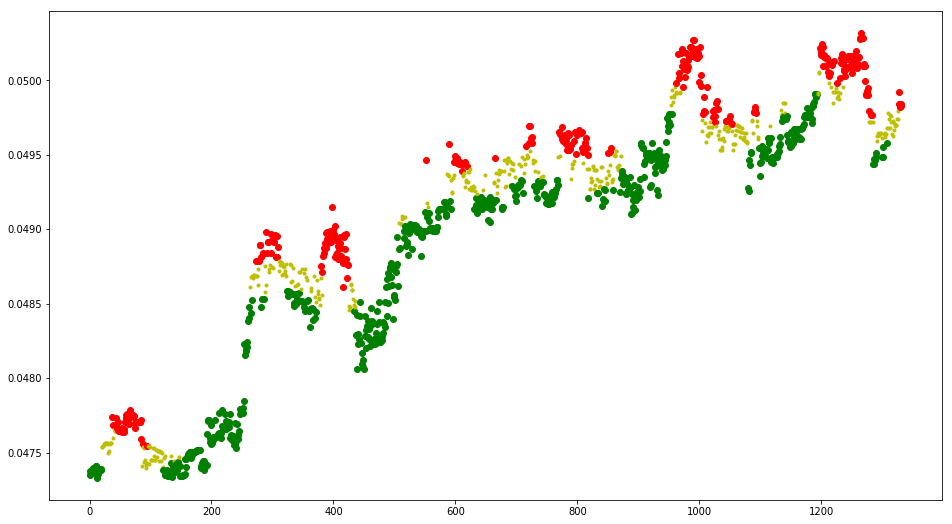

In [109]:
fig, ax = plt.subplots()

markers = ['ro' if label == -1 else 'go' if label == 1 else 'y.' for label in y]

for i, wamp in enumerate(wamps[:-delay]):    
    ax.plot(i, wamps[i], markers[i])
    
plt.show()

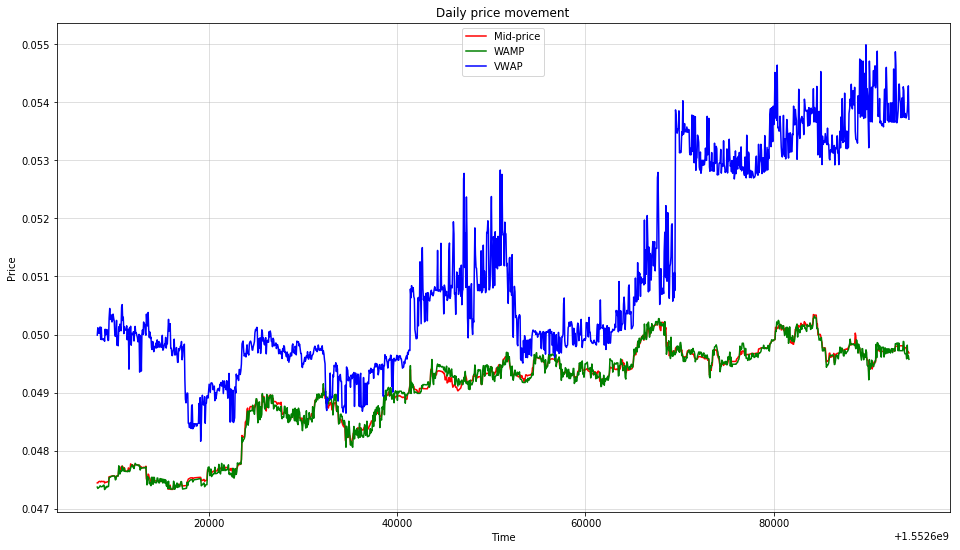

In [110]:
functions.plot_price_movement(dataset)

In [188]:
n_days = 10
n_asset_pairs = 25

n_files = len(snapshots_file_list)
n_ss_per_file = 1440

ss_shape = (200, 3)

dataset = np.zeros([n_files*n_ss_per_file], 
                   dtype=[('snapshot', np.float32, ss_shape), ('timestamp', np.float32, 1), ('wamp', np.float32, 1),('label', int, 1)])

In [189]:
global_cnt = 0

alpha = 0.002

delay = 100

for i in range(n_asset_pairs):
    asset_pair_cnt = 0
    
    for j in range(n_days):
        data = np.loadtxt(snapshots_file_list[i*n_days+j], delimiter=',')
        
        for j, ss in enumerate(data):
            snapshot = ss[:-1].reshape(-1, 3)
            timestamp = ss[-1]
            wamp = functions.calc_WAMP(ss)

            dataset[global_cnt]["snapshot"] = snapshot
            dataset[global_cnt]["timestamp"] = timestamp
            dataset[global_cnt]["wamp"] = wamp

            # calculate label for the last snapshot for which enough data is provided with this snapshot
            if asset_pair_cnt >= delay:
                mean = np.mean(dataset["wamp"][global_cnt-delay+1:global_cnt+1])
                act_wamp = dataset["wamp"][global_cnt-delay]
                
                if mean - act_wamp < -(act_wamp*alpha):
                    dataset[global_cnt-delay]["label"] = -1

                elif mean - act_wamp > act_wamp*alpha:
                    dataset[global_cnt-delay]["label"] = 1

                else:
                    dataset[global_cnt-delay]["label"] = 0
            
            asset_pair_cnt += 1
            global_cnt += 1
            
    # set back global_cnt to overwrite not labeled data (last delay number of elements)
    global_cnt = global_cnt-delay+1

dataset = dataset[:global_cnt]

In [190]:
len(dataset)

355122

In [191]:
nb_samples = len(dataset)

valid_split = 0.2

In [192]:
#shuffle the dataset
np.random.shuffle(dataset)

In [193]:
# train-valid-test split and one-hot encoding (dataset prep)
#input
X_train = dataset['snapshot'][0:int(nb_samples*(1-valid_split))]
X_valid = dataset['snapshot'][int(nb_samples*(1-valid_split)):]

#output
Y_train = dataset['label'][0:int(nb_samples*(1-valid_split))]
Y_valid = dataset['label'][int(nb_samples*(1-valid_split)):]

In [194]:
X_train.shape

(284097, 200, 3)

In [195]:
logreg = linear_model.LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
model = logreg.fit(X_train.reshape(-1, 600),Y_train)

In [196]:
logreg.score(X_valid.reshape(-1, 600),Y_valid)

0.5779936642027456

In [197]:
predictions = logreg.predict(X_valid.reshape(-1, 600))

In [208]:
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [209]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[  521 13854     1]
 [  727 40530     0]
 [  400 14991     1]]
Normalized confusion matrix
[[3.62e-02 9.64e-01 6.96e-05]
 [1.76e-02 9.82e-01 0.00e+00]
 [2.60e-02 9.74e-01 6.50e-05]]


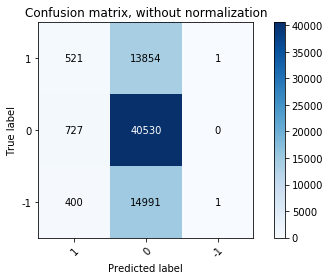

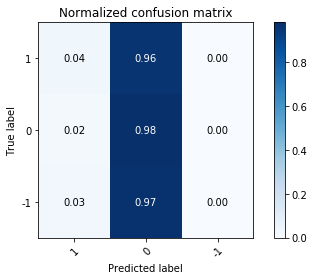

In [210]:
class_names = [1, 0, -1]

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_valid, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_valid, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()